## Calculate ENSO Skill as a Function of Initial Month vs. Lead Time

### In this example, we demonstrate: 
1. How to remotely access data from the North American Multi-model Ensemble (NMME) hindcast database and set it up to be used in `climpred` leveraging `dask`.
2. How to calculate the Anomaly Correlation Coefficient (ACC) using monthly data
3. How to calculate and plot historical forecast skill of the Nino3.4 index as function of initialization month and lead time.

### The North American Multi-model Ensemble (NMME)

Further information on NMME is available from [Kirtman et al. 2014](https://journals.ametsoc.org/doi/full/10.1175/BAMS-D-12-00050.1) and the [NMME project website](https://www.cpc.ncep.noaa.gov/products/NMME/)

The NMME public database is hosted on the International Research Institute for Climate and Society (IRI) data server http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/

Since the NMME data server is accessed via this notebook, the time for the notebook to run may take a few minutes and vary depending on the speed that data is downloaded.

### Definitions

**Anomalies**
: Departure from normal, where normal is defined as the climatological value based on the average value for each month over all years.

**Nino3.4**
: An index used to represent the evolution of the El Nino-Southern Oscillation (ENSO). Calculated as the average sea surface temperature (SST) anomalies in the region 5S-5N; 190-240

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

from climpred import HindcastEnsemble
import climpred

Function to set 360 calendar to 360_day calendar and decond cf times

In [2]:
def decode_cf(ds, time_var):
    """Decodes time dimension to CFTime standards."""
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

We originally loaded in the monthly sea surface temperature (SST) hindcast data for the NCEP-CFSv2 model from the NMME data server. This is a large dataset (~20GB), so we chunked it with `dask`, pre-emptively took the ensemble mean, and saved it out locally as a smaller NetCDF. You can process this completely from the cloud, but things run a lot quicker if you can save it locally. 

We take the ensemble mean here, since we are just using deterministic metrics in this example. `climpred` will automatically take the mean over the ensemble while evaluating metrics with `comparison='e2o'`, but this should make things more efficient so it doesn't have to be done multiple times.

```python
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/dods'
fcstds = xr.open_dataset(url, decode_times=False, chunks={'S': 'auto', 'L': 'auto', 'M': -1})
fcstds = decode_cf(fcstds, 'S')
fcstds = fcstds.mean('M').compute()
fcstds.to_netcdf('NCEP-CFSv2.SST.nc')
```

In [3]:
fcstds = xr.open_dataset('NCEP-CFSv2.SST.nc')

The NMME data dimensions correspond to the following `climpred` dimension definitions: `X=lon`,`L=lead`,`Y=lat`,`M=member`, `S=init`.  We will rename the dimensions to their `climpred` names.

In [4]:
fcstds = fcstds.rename({'S': 'init',
                        'L': 'lead',
                        'X': 'lon',
                        'Y': 'lat'})

Let's make sure that the `lead` dimension is set properly for `climpred`.  NMME data stores `leads` as 0.5, 1.5, 2.5, etc, which correspond to 0, 1, 2, ... months since initialization. We will change the `lead` to be integers starting with zero.  `climpred` also requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years,seasons,months,weeks,pentads,days`.  For the monthly NMME data, the `lead` `units` are `months`.  

In [5]:
fcstds['lead'] = (fcstds['lead'] - 0.5).astype('int')
fcstds['lead'].attrs = {'units': 'months'}

Next, we want to get the verification SST data from the data server. It's a lot smaller, so we don't need to worry about saving it out locally. We keep the spatial dimension as one full chunk since we'll be averaging over the Nino3.4 box soon.

In [6]:
obsurl='http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.OIv2_SST/.sst/dods'
verifds = xr.open_dataset(obsurl, decode_times=False, chunks={'T': 'auto', 'X': -1, 'Y': -1})
verifds = decode_cf(verifds, 'T')
verifds

<xarray.Dataset>
Dimensions:  (T: 405, X: 360, Y: 181)
Coordinates:
  * T        (T) object 1982-01-16 00:00:00 ... 2015-09-16 00:00:00
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    sst      (T, Y, X) float32 dask.array<chunksize=(405, 181, 360), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL

Rename the dimensions to correspond to `climpred` dimensions.

In [7]:
verifds = verifds.rename({'T': 'time',
                          'X': 'lon',
                          'Y': 'lat'})

Convert the `time` data to be on the first of the month and in the same calendar format as the forecast output. The time dimension is natively decoded to start in February, even though it starts in January. It is also labelled as mid-month, and we need to label it as the start of the month to ensure that the dates align properly.

In [8]:
verifds['time'] = xr.cftime_range(start='1982-01', periods=verifds['time'].size, freq='MS', calendar='360_day')

Subset the data to 1982-2010

In [9]:
fcstds = fcstds.sel(init=slice('1982-01-01', '2010-12-01'))
verifds = verifds.sel(time=slice('1982-01-01', '2010-12-01'))

Calculate the Nino3.4 index for forecast and verification.

In [10]:
fcstnino34 = fcstds.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(['lat','lon'])
verifnino34 = verifds.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(['lat','lon'])

fcstclimo = fcstnino34.groupby('init.month').mean('init')
fcst = (fcstnino34.groupby('init.month') - fcstclimo)

verifclimo = verifnino34.groupby('time.month').mean('time')
verif = (verifnino34.groupby('time.month') - verifclimo)

/Users/rileybrady/miniconda3/envs/climpred-dev/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 29 times more chunks
  return self.array[key]


Now we run `dask`'s compute command to load the forecast and verification into memory. We are averaging them down to a single time series index to represent the ENSO index, which makes the data quite small. The overhead cost of `dask` actually makes skill computation slower out-of-memory with these file sizes.

In [11]:
%time verif = verif.compute()

CPU times: user 64.1 ms, sys: 20.6 ms, total: 84.7 ms
Wall time: 546 ms


Use the `climpred.HindcastEnsemble` to calculate the anomaly correlation coefficient (ACC) as a function of initialization month and lead. We use `xarray`'s `.groupby()` to create sub-groups based on the month they were initialized in.


In [12]:
%%time
result = []
for label, group in fcst.groupby('init.month'):
    hindcast = HindcastEnsemble(group)
    hindcast = hindcast.add_observations(verif)
    skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')
    result.append(skill)

result = xr.concat(result, dim='month')
result['month'] = np.arange(12) + 1

CPU times: user 1.04 s, sys: 16.9 ms, total: 1.06 s
Wall time: 1.05 s


Plot the ACC as function of Initial Month and lead-time

Text(0, 0.5, 'Lead Time (Months)')

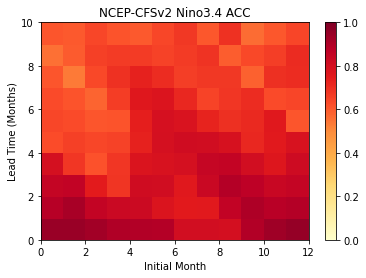

In [13]:
plt.pcolormesh(result.sst.transpose(),
               cmap='YlOrRd',
               vmin=0.0,
               vmax=1.0)
plt.colorbar()
plt.title('NCEP-CFSv2 Nino3.4 ACC')
plt.xlabel('Initial Month')
plt.ylabel('Lead Time (Months)')

### References

1. Kirtman, B.P., D. Min, J.M. Infanti, J.L. Kinter, D.A. Paolino, Q. Zhang, H. van den Dool, S. Saha, M.P. Mendez, E. Becker, P. Peng, P. Tripp, J. Huang, D.G. DeWitt, M.K. Tippett, A.G. Barnston, S. Li, A. Rosati, S.D. Schubert, M. Rienecker, M. Suarez, Z.E. Li, J. Marshak, Y. Lim, J. Tribbia, K. Pegion, W.J. Merryfield, B. Denis, and E.F. Wood, 2014: The North American Multimodel Ensemble: Phase-1 Seasonal-to-Interannual Prediction; Phase-2 toward Developing Intraseasonal Prediction. Bull. Amer. Meteor. Soc., 95, 585–601, https://doi.org/10.1175/BAMS-D-12-00050.1